# Project: Spark (USCensus)

<br>

## Questions to address:
- How does the number of people of different ages varied between 1980 and 2010 in the US?
- How is the total number of people evolving with time?

<br>

## Tools:
- use sqlContext.read.json to read data and registerTempTable() to register them and create a local database
- use SQl queries to explore the data and merge census from different years
- df.toPandas() to convert data to pandas dataframe and do plots

<br>

### load defaults

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 14, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))


#specific to this project
import pyspark
from pyspark.sql import SQLContext

print("Defaults Loaded")

Defaults Loaded


In [16]:
#sc.stop()
sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)

df = sqlContext.read.json("./data/census_2010.json")
df.registerTempTable('census2010')
df = sqlContext.read.json('./data/census_1980.json')
df.registerTempTable('census1980')
df = sqlContext.read.json('./data/census_1990.json')
df.registerTempTable('census1990')
df = sqlContext.read.json('./data/census_2000.json')
df.registerTempTable('census2000')

tables = sqlContext.tableNames()
print(tables)

['census1980', 'census1990', 'census2000', 'census2010']


print top 5 rows from the 2010 Census 

In [17]:
query = 'select * from census2010'
df = sqlContext.sql(query)
df.show(5)

+---+-------+-------+-------+----+
|age|females|  males|  total|year|
+---+-------+-------+-------+----+
|  0|1994141|2085528|4079669|2010|
|  1|1997991|2087350|4085341|2010|
|  2|2000746|2088549|4089295|2010|
|  3|2002756|2089465|4092221|2010|
|  4|2004366|2090436|4094802|2010|
+---+-------+-------+-------+----+
only showing top 5 rows



print summary statistics for the number of males and females in the 2010 census

In [18]:
query = 'select males, females from census2010'
df = sqlContext.sql(query)
df.describe().show()

+-------+------------------+-----------------+
|summary|             males|          females|
+-------+------------------+-----------------+
|  count|               101|              101|
|   mean|1520095.3168316833|1571460.287128713|
| stddev|  818587.208016823|748671.0493484351|
|    min|              4612|            25673|
|    max|           2285990|          2331572|
+-------+------------------+-----------------+



print top 2 rows for the totals of different years 

In [19]:
query = """select c1.age, 
                  c1.total as total_2010, 
                  c2.total  as total_2000,
                  c3.total  as total_1990,
                  c4.total  as total_1980
             from census2010 c1 
       inner join census2000 c2 on c1.age=c2.age
       inner join census1990 c3 on c1.age=c3.age
       inner join census1980 c4 on c1.age=c4.age
       """
df = sqlContext.sql(query)
df.show(2)

+---+----------+----------+----------+----------+
|age|total_2010|total_2000|total_1990|total_1980|
+---+----------+----------+----------+----------+
|  0|   4079669|   3733034|   3857376|   3438584|
|  1|   4085341|   3825896|   3854707|   3367035|
+---+----------+----------+----------+----------+
only showing top 2 rows



<br>

### Question 1: How does the number of people of different ages varied between 1980 and 2010 in the US?

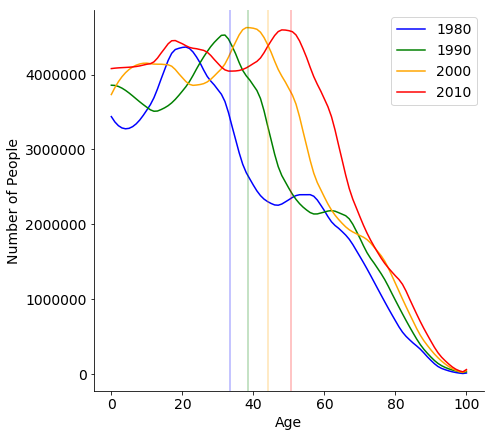

In [20]:
pandas_df = df.toPandas()
sns.set_style() 

plt_color=['blue', 'green', 'orange', 'red']

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(pandas_df['age'], pandas_df['total_1980'], label='1980', color=plt_color[0])
ax.plot(pandas_df['age'], pandas_df['total_1990'], label='1990', color=plt_color[1])
ax.plot(pandas_df['age'], pandas_df['total_2000'], label='2000', color=plt_color[2])
ax.plot(pandas_df['age'], pandas_df['total_2010'], label='2010', color=plt_color[3])

ax.set_xlabel('Age'), ax.set_ylabel('Number of People')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

mean_Age = sum(pandas_df['total_1980']*pandas_df['age'])/sum(pandas_df['total_1980'])
ax.axvline(mean_Age, alpha=0.3, color=plt_color[0])
mean_Age = sum(pandas_df['total_1990']*pandas_df['age'])/sum(pandas_df['total_1980'])
ax.axvline(mean_Age, alpha=0.3, color=plt_color[1])
mean_Age = sum(pandas_df['total_2000']*pandas_df['age'])/sum(pandas_df['total_1980'])
ax.axvline(mean_Age, alpha=0.3, color=plt_color[2])
mean_Age = sum(pandas_df['total_2010']*pandas_df['age'])/sum(pandas_df['total_1980'])
ax.axvline(mean_Age, alpha=0.3, color=plt_color[3])

plt.legend()
plt.show()

overall the population is getting older, with two peaks of people born in 1960 and 1990

<br>

### Question 2 - How is the total number of people evolving with time?

In [21]:
query="""select sum(c1.total) as total_2010, 
                sum(c2.total) as total_2000, 
                sum(c3.total) as total_1990,
                sum(c4.total) as total_1980
           from census2010 c1
     inner join census2000 c2 on c2.age=c1.age
     inner join census1990 c3 on c3.age=c1.age
     inner join census1980 c4 on c4.age=c1.age"""
df = sqlContext.sql(query)
df.show()

+----------+----------+----------+----------+
|total_2010|total_2000|total_1990|total_1980|
+----------+----------+----------+----------+
| 312247116| 284594395| 254506647| 230176361|
+----------+----------+----------+----------+



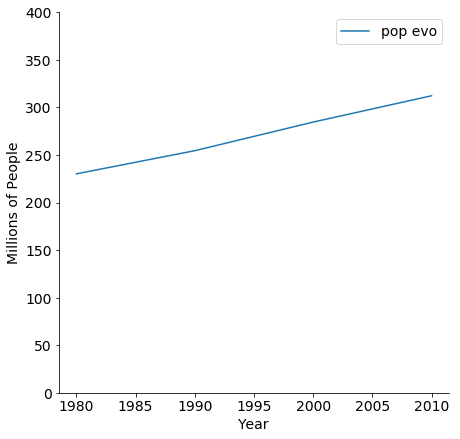

In [22]:
pandas_df = df.toPandas()
sns.set_style() 

ylim=[0,400]

year = np.array([1980, 1990, 2000, 2010])
pop = np.array([pandas_df['total_1980'], pandas_df['total_1990'], 
                pandas_df['total_2000'], pandas_df['total_2010']])

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(year, pop/1e6, label='pop evo')

ax.set_xlabel('Year'), ax.set_ylabel('Millions of People')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim(ylim)

plt.legend()
plt.show()

the US population is still growing significantly